# Which Programming Language?

The aim of this is a multiclass classifier. Given an unseen set of StackOverflow titles, predict the programming language it is related to

## Libraries

### Colaboratory Specific Code

This mounts your Google Drive folder so you can access it from Colaboratory

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

We also want to change the working directory so that the file references work. Here I've places the files for this class inside a folder called 'class_1' that itself is inside a folder called 'NLP_class'.

In [9]:
# %cd drive/My\ Drive/NLP_class/0719_question
# !ls

In [10]:
# !pip install scikit-plot

### Dependencies

In [11]:
import pandas as pd
from sklearn.utils import shuffle
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
import scikitplot as skplt
from scikitplot.metrics import plot_confusion_matrix

# Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD

# Saving models
import _pickle as pickle

np.random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(n_splits=5, random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    plot_confusion_matrix(y, preds)
    
    return preds


## Define Models

Change LOAD_MODELS to 1 to load saved models from file

In [13]:
LOAD_MODELS = 0

In [80]:
if LOAD_MODELS == 0:
    print("Program will train new models")
    # CSR Set
    linr = linear_model.LinearRegression(n_jobs = -1)

    lr = linear_model.LogisticRegression(solver='newton-cg', C=5, penalty='l2', n_jobs=-1, multi_class='auto')

    rf = RandomForestClassifier(criterion='gini', max_depth=5, 
                               min_samples_leaf=5, min_samples_split=2, 
                               n_estimators = 220, oob_score=True, 
                               max_features=0.5, n_jobs = -1, random_state=42)

    # Dimension Reduced Set
    nb_sv = GaussianNB()

    linr_sv = linear_model.LinearRegression(n_jobs = -1)

    lr_sv = linear_model.LogisticRegression(solver='newton-cg', C=5, penalty='l2', n_jobs=-1, multi_class='auto')

    rf_sv = RandomForestClassifier(criterion='gini', max_depth=5, 
                                   min_samples_leaf=5, min_samples_split=2, 
                                   n_estimators = 220, oob_score=True, 
                                   max_features=0.5, n_jobs = -1, random_state=42)
else:
    print("Program will load existing models if available")

    linr = pickle.load( open( "q2/linr.p", "rb" ) )
    lr = pickle.load( open( "q2/lr.p", "rb" ) )
    rf = pickle.load( open( "q2/rf.p", "rb" ) )
    
    nb_sv = pickle.load( open( "q2/nb_sv.p", "rb" ) )
    linr_sv = pickle.load( open( "q2/linr_sv.p", "rb" ) )
    lr_sv = pickle.load( open( "q2/lr_sv.p", "rb" ) )
    rf_sv = pickle.load( open( "q2/rf_sv.p", "rb" ) )
    

Program will train new models


## Pre-process the data

This code cleans the text

In [15]:
# There is a problem with this codes as it is possible for all words to be removed leaving a null value
# This is solved in line 25 with the if statement

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE, "", text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " " + text + " "
    for sw in STOPWORDS:
        text = text.replace(" "+sw+" ", " ") # delete stopwords from text
    text = re.sub('[ ][ ]+', " ", text)

    #     print("text:", text)
#     print(len(text))
    
    if len(text) > 1: # only run if there are words present
      if text[0] == ' ':
          text = text[1:]
      if text[-1] == ' ':
          text = text[:-1]
        
    return text

### Inspect Data
Let's see what the data looks like

In [16]:
dialogues = pd.read_csv('dialogues.tsv', sep='\t')
tagged = pd.read_csv('tagged_posts.tsv', sep='\t')

In [17]:
dialogues.head(2)

,text,tag
0,Okay -- you're gonna need to learn how to lie.,dialogue
1,I'm kidding. You know how sometimes you just ...,dialogue


In [18]:
tagged.head(2)

,post_id,title,tag
0,9,Calculate age in C#,c#
1,16,Filling a DataSet or DataTable from a LINQ que...,c#


### Clean the Text and Assign Labels

First we load in the StackOverflow dataset and drop the unused post_id column

In [19]:
tagged.head()

,post_id,title,tag
0,9,Calculate age in C#,c#
1,16,Filling a DataSet or DataTable from a LINQ que...,c#
2,39,Reliable timer in a console application,c#
3,42,Best way to allow plugins for a PHP application,php
4,59,"How do I get a distinct, ordered list of names...",c#


In [20]:
stackover = tagged.drop(columns=['post_id'])
stackover.head()

,title,tag
0,Calculate age in C#,c#
1,Filling a DataSet or DataTable from a LINQ que...,c#
2,Reliable timer in a console application,c#
3,Best way to allow plugins for a PHP application,php
4,"How do I get a distinct, ordered list of names...",c#


In [21]:
relevant_stack = [text_prepare(x) for x in stackover['title']]
clean_titles = pd.DataFrame({'clean_data': relevant_stack})
clean_titles.head()

,clean_data
0,calculate age c#
1,filling dataset datatable linq query result set
2,reliable timer console application
3,best way allow plugins php application
4,get distinct ordered list names datatable usin...


In [22]:
clean_stack = pd.concat([clean_titles, stackover], axis = 1, ignore_index=True)
clean_stack = shuffle(clean_stack)
clean_stack.head()

,0,1,2
105377,rails comparing dates,Rails comparing dates,ruby
373455,convert listt observablecollectiont wp7,Convert List<T> to ObservableCollection<T> in WP7,c#
162616,python repl python application,Python repl in python application,python
13327,customizing pop background color ie7 open popu...,Customizing pop up background color with IE7 o...,javascript
2879,retrieve multiple rows odbc source union query,Retrieve multiple rows from an ODBC source wit...,c_cpp


In [23]:
clean_stack = clean_stack.drop(columns=[1])
clean_stack.head(15)

,0,2
105377,rails comparing dates,ruby
373455,convert listt observablecollectiont wp7,c#
162616,python repl python application,python
13327,customizing pop background color ie7 open popu...,javascript
2879,retrieve multiple rows odbc source union query,c_cpp
343976,equivalent curve ggplot,r
201636,using different http scheme port setup done st...,java
4335,looking uptodate eclipse plugin c#,c#
36597,field validation ip address,c#
281935,android reading large file,java


Check how many unique labels we have

In [24]:
unique_languages = clean_stack.groupby(2).nunique()
unique_languages.head(15)

,0,2
2,,
c#,93828,1
c_cpp,63917,1
java,63149,1
javascript,49696,1
php,56746,1
python,33262,1
r,2390,1
ruby,23572,1
swift,3,1


Now we convert these categorical labels into numericals ones

In [25]:
clean_stack[2] = clean_stack[2].astype('category')
clean_stack["label"] = clean_stack[2].cat.codes
clean_stack.head(10)

,0,2,label
105377,rails comparing dates,ruby,7
373455,convert listt observablecollectiont wp7,c#,0
162616,python repl python application,python,5
13327,customizing pop background color ie7 open popu...,javascript,3
2879,retrieve multiple rows odbc source union query,c_cpp,1
343976,equivalent curve ggplot,r,6
201636,using different http scheme port setup done st...,java,2
4335,looking uptodate eclipse plugin c#,c#,0
36597,field validation ip address,c#,0
281935,android reading large file,java,2


In [26]:
clean_stack = clean_stack.drop(columns=[2])
clean_stack.head()

,0,label
105377,rails comparing dates,7
373455,convert listt observablecollectiont wp7,0
162616,python repl python application,5
13327,customizing pop background color ie7 open popu...,3
2879,retrieve multiple rows odbc source union query,1


### Train Test Validation Split

In [27]:
stack_data = clean_stack[0]
stack_data.head()

105377                                rails comparing dates
373455              convert listt observablecollectiont wp7
162616                       python repl python application
13327     customizing pop background color ie7 open popu...
2879         retrieve multiple rows odbc source union query
Name: 0, dtype: object

In [28]:
stack_labels = clean_stack['label']
stack_labels.head()

105377    7
373455    0
162616    5
13327     3
2879      1
Name: label, dtype: int8

First we split off the validation set as 20% of the overall data set.

In [29]:
df_data, X_val, df_labels, y_val = train_test_split(
    stack_data, stack_labels, test_size=0.2, random_state=42, shuffle=False)

Then we split the remaining into training and test data.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.25,
                                                        random_state=42,
                                                        shuffle=False)

The end result is 60% training data, 20% test data and 20% validation data

In [31]:
print("Shape of X_train", X_train.shape)
print("Shape of y_train", X_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)
print("Shape of X_val", X_val.shape)
print("Shape of y_val", y_val.shape)

Shape of X_train (238120,)
Shape of y_train (238120,)
Shape of X_test (79374,)
Shape of y_test (79374,)
Shape of X_val (79374,)
Shape of y_val (79374,)


### Apply TF-IDF Weighting

We first need to learn the words for the dictionary from our training data.

In [32]:
vectorizer = TfidfVectorizer(norm=u'l1', token_pattern='(\S+)', min_df=5, max_df=0.9, ngram_range=(1,2))

%time vectorizer.fit_transform(X_train)
# print(vectorizer.get_feature_names(10))

Wall time: 4.1 s


<238120x39308 sparse matrix of type '<class 'numpy.float64'>'
	with 1640768 stored elements in Compressed Sparse Row format>

Apply this learned TF-IDF transform to our different dataframes

In [33]:
%time train_tf = vectorizer.transform(X_train)
# train_tf = csr_matrix.mean(train_tf, axis=0)

%time test_tf = vectorizer.transform(X_test)
# test_tf = csr_matrix.mean(test_tf, axis=0)

%time val_tf = vectorizer.transform(X_val)
# val_tf = csr_matrix.mean(val_tf, axis=0)


Wall time: 2.27 s
Wall time: 809 ms
Wall time: 825 ms


We can see that the different dataframes have been transformed intt Compressed Sparse Row format data. This is very important as sparsity has a big impact on accuracy.

In [34]:
print("Shape of train_tf", train_tf.shape)

print("Shape of test_tf", test_tf.shape)

print("Shape of val_tf", val_tf.shape)

Shape of train_tf (238120, 39308)
Shape of test_tf (79374, 39308)
Shape of val_tf (79374, 39308)


In [35]:
true_label = y_test.values

## Classify CSR

First we will attempt to classify the full CSR dataset

### Naive Bayes
Interestingly this crashes and causes the runtime to reset as the dimensionality is too high.

In [36]:
# nb = GaussianNB()
# nb.fit(train_tf.todense(), y_train.astype(int))

In [37]:
# nb_score_test = nb.score(test_tf.todense(), y_test.astype(int))
# nb_score_test

### Linear Regression

In [38]:
if LOAD_MODELS == 0:
    %time linr.fit(train_tf, y_train.astype(int))

Wall time: 10.2 s


In [39]:
# %time linr_score_test = linr.score(test_tf, y_test.astype(int))
# print(linr_score_test*100

In [40]:
%time scores = cross_val_score(linr, test_tf, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Wall time: 16.6 s
Accuracy: -0.08 (+/- 0.07)


We don't have a confusion matrix for the LR as it returns continuous results not discrete ones

### Logistic Regression

In [81]:
if LOAD_MODELS == 0:
    %time lr.fit(train_tf, y_train)

Wall time: 58.5 s


In [42]:
# %time lr_score_test = lr.score(test_tf, y_test.astype(int))
# print(lr_score_test*100)
# %time scores = cross_val_score(lr, test_tf, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

We can better understand the accuracy by looking at a confusion matrix




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished


Log loss: 1.0874234493348576
Accuracy: 0.6745785773679038


array([0, 0, 0, ..., 5, 3, 0], dtype=int8)

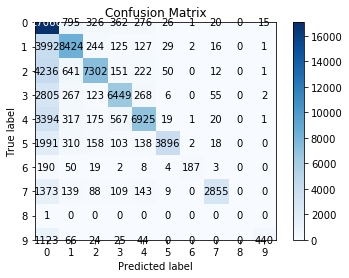

In [43]:
evaluate_features(test_tf, y_test, lr)

### Support Vector Machine
The high dimensionality means that this takes a ridiculous amount of time to run.

In [44]:
# clf = svm.SVC(kernel='linear', C=1, random_state=42)
# %time clf.fit(train_tf, y_train.astype(int))

In [45]:
# %time clf_score = clf.score(test_tf, y_test.astype(int))
# print("SVM accuracy on test:\t %f" % clf_score)

### Random Forest
The high dimensionality means that this takes a ridiculous amount of time to run.

In [46]:
if LOAD_MODELS == 0:
    %time rf.fit(train_tf, y_train.astype(int))

Wall time: 39.5 s


In [47]:
# %time rf_score = rf.score(test_tf, y_test.astype(int))
# print("RF accuracy on test:\t %f" % rf_score)
# %time scores = cross_val_score(rf, test_tf, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.0min remaining:  1.3min


Log loss: 1.5747267643829912
Accuracy: 0.4476276866480208


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


array([0, 0, 0, ..., 5, 3, 0], dtype=int8)

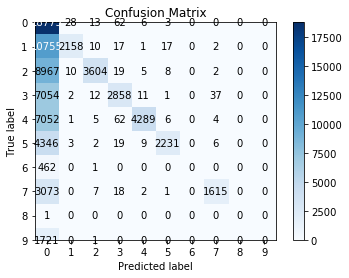

In [48]:
evaluate_features(test_tf, y_test, rf)

We could use a gridsearch to find optimal paramters for a classifier

In [49]:
# rf_grid = RandomForestClassifier(random_state=42)

# param_grid = { 
#     'n_estimators': [100, 120, 140, 160, 180, 200, 220, 240, 260],
#     'min_samples_leaf': [3, 5, 7],
#     'min_samples_split': [2, 3, 4, 5, 6],
#     'max_depth' : [5, 10, 15, 20, 25, 30, 35, 40, 45],
#     'criterion' :['gini', 'entropy']
# }


# CV_rf = GridSearchCV(estimator=rf_grid, param_grid=param_grid, cv= 5, n_jobs = -1, 
#                      verbose = 2)
# CV_rf.fit(train_tf, y_train.astype(int))
# CV_rf.best_params_

## Scores on CSR Validation Set

In [50]:
# nb_score_val = nb.score(val_tf.todense(), y_val.astype(int))
# nb_score_val

In [51]:
# linr_score_val = linr.score(val_tf, y_val)
# linr_score_val
%time scores = cross_val_score(linr, val_tf, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Wall time: 16 s
Accuracy: -0.09 (+/- 0.09)


In [52]:
# lr_score_val = lr.score(val_tf, y_val.astype(int))
# lr_score_val
%time scores = cross_val_score(lr, val_tf, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 7.4 s
Accuracy: 0.78 (+/- 0.00)


In [53]:
# clf_score_val = clf.score(X_val, y_val.astype(int))
# clf_score_val

In [54]:
# rf_score_val = rf.score(val_tf, y_val.astype(int))
# rf_score_val
%time scores = cross_val_score(rf, val_tf, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Wall time: 2min 15s
Accuracy: 0.50 (+/- 0.02)


## Classify Reduced
We will now reduce the dimensionality of the dataset and rety classification.

### Reduce Dimensions using SVD

In [55]:
NUM_DIMEN = 50
svd = TruncatedSVD(n_components=NUM_DIMEN)

In [56]:
%time train_sv = svd.fit_transform(train_tf)
var = svd.explained_variance_.sum() * 100
print("Training data variance with %d SVD components is %f" % (NUM_DIMEN, var))

Wall time: 5.18 s
Training data variance with 50 SVD components is 1.746733


In [57]:
%time test_sv = svd.fit_transform(test_tf)
%time val_sv = svd.fit_transform(val_tf)

Wall time: 1.78 s
Wall time: 1.75 s


In [58]:
print("Shape of train_sv", train_sv.shape)

print("Shape of test_sv", test_sv.shape)

print("Shape of val_sv", val_sv.shape)

Shape of train_sv (238120, 50)
Shape of test_sv (79374, 50)
Shape of val_sv (79374, 50)


### Naive Bayes
With the reduced dimensionality we can use a Naive Bayes classifier

In [59]:
if LOAD_MODELS == 0:
    %time nb_sv.fit(train_sv, y_train.astype(int))

Wall time: 290 ms


In [60]:
# %time nb_score_test_sv = nb_sv.score(test_sv, y_test.astype(int))
# nb_score_test_sv*100
# %time scores = cross_val_score(nb_sv, test_sv, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Log loss: 5.028020678482407
Accuracy: 0.3656612996699171


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


array([0, 0, 0, ..., 5, 3, 6], dtype=int8)

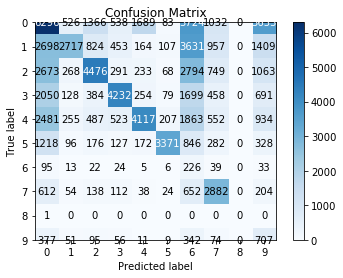

In [61]:
evaluate_features(test_sv, y_test, nb_sv)

### Linear Regression

In [62]:
if LOAD_MODELS == 0:
    %time linr_sv.fit(train_sv, y_train.astype(int))

Wall time: 408 ms


In [63]:
# %time linr_score_test_sv = linr_sv.score(test_sv, y_test.astype(int))
# linr_score_test_sv*100

In [64]:
%time scores = cross_val_score(linr_sv, test_sv, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Wall time: 504 ms
Accuracy: 0.28 (+/- 0.02)


We don't have a confusion matrix for the LR as it returns continuous results not discrete ones

### Logistic Regression

In [65]:
if LOAD_MODELS == 0:
    %time lr_sv.fit(train_sv, y_train.values)

C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 42.8 s


In [66]:
# %time lr_score_test_sv = lr_sv.score(test_sv, true_label)
# print("Accuracy: ", lr_score_test_sv)
# %time scores = cross_val_score(lr_sv, test_sv, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   13.6s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.6s finished


Log loss: 1.3529716919709465
Accuracy: 0.5442840224758737


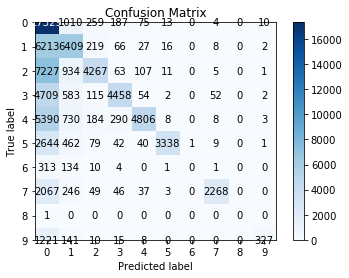

In [67]:
preds = evaluate_features(test_sv, true_label, lr_sv)

Explore the predictions compared to actual labels

In [68]:
# Match is 'True' when values are the same
match = [preds[x] == true_label[x] for x in range(len(preds))]

# Combine and show
df_compare = pd.DataFrame({'Predictions': preds, 'Actual': true_label, 
                           'Match': match})

print('Show performance on first 5 rows')
df_compare.head(10)

Show performance on first 5 rows


,Predictions,Actual,Match
0,0,1,False
1,0,2,False
2,0,4,False
3,0,1,False
4,0,2,False
5,0,0,True
6,0,1,False
7,0,2,False
8,0,2,False
9,0,3,False


### Support Vector Machine
Even at low dimension this takes a lot of time to run.

In [69]:
# clf_sv = svm.SVC(kernel='linear', C=1, random_state=42)
# %time clf_sv.fit(train_sv, y_train.astype(int))

In [70]:
# %time clf_score_sv = clf_sv.score(test_sv, y_test.astype(int))
# print("SVM accuracy on test:\t %f" % clf_score_sv)

### Random Forest

In [71]:
if LOAD_MODELS == 0:
    %time rf_sv.fit(train_sv, y_train.astype(int))

Wall time: 1min 34s


In [72]:
# %time rf_score_sv = rf_sv.score(test_sv, y_test.astype(int))
# print("RF accuracy on test:\t %f" % rf_score_sv)
# %time scores = cross_val_score(rf_sv, test_sv, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Log loss: 1.4947142731343623
Accuracy: 0.48389900975130395


array([0, 0, 0, ..., 5, 3, 1], dtype=int8)

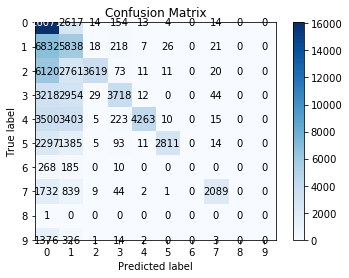

In [73]:
evaluate_features(test_sv, true_label, rf_sv)

## Scores on Reduced Validation Set

In [74]:
%time scores = cross_val_score(nb_sv, val_sv, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Wall time: 858 ms
Accuracy: 0.39 (+/- 0.02)


In [75]:
%time scores = cross_val_score(linr_sv, val_sv, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Wall time: 503 ms
Accuracy: 0.26 (+/- 0.02)


In [76]:
%time scores = cross_val_score(lr_sv, val_sv, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Andrew\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.",

Wall time: 37.5 s
Accuracy: 0.62 (+/- 0.01)


In [77]:
# clf_score_val = clf.score(X_val, y_val.astype(int))
# clf_score_val

In [78]:
%time scores = cross_val_score(rf_sv, val_sv, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Wall time: 1min 44s
Accuracy: 0.53 (+/- 0.01)


## Let's Save Everything

In [83]:
if LOAD_MODELS == 0:    
    pickle.dump( linr, open( "q2/linr.p", "wb" ) )
    pickle.dump( lr, open( "q2/lr.p", "wb" ) )
    pickle.dump( rf, open( "q2/rf.p", "wb" ) )

    pickle.dump( nb_sv, open( "q2/nb_sv.p", "wb" ) )
    pickle.dump( linr_sv, open( "q2/linr_sv.p", "wb" ) )
    pickle.dump( lr_sv, open( "q2/lr_sv.p", "wb" ) )
    pickle.dump( rf_sv, open( "q2/rf_sv.p", "wb" ) )
    
print("Done!")

Done!
